<a href="https://colab.research.google.com/github/danielsoy/ALOCC-CVPR2018/blob/master/Copia_de_funka_alibi1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os
import shutil
from collections import Counter
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Dense, Layer, Reshape, InputLayer, Flatten, Input, MaxPooling2D




In [3]:
!git clone https://github.com/SeldonIO/alibi-detect.git





Cloning into 'alibi-detect'...
remote: Enumerating objects: 4042, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4042 (delta 0), reused 0 (delta 0), pack-reused 4038
Receiving objects: 100% (4042/4042), 26.09 MiB | 31.40 MiB/s, done.
Resolving deltas: 100% (2586/2586), done.


In [4]:
%cd /content/alibi-detect/alibi_detect/od

/content/alibi-detect/alibi_detect/od


In [5]:
!pip install alibi-detect

     |████████████████████████████████| 300 kB 5.1 MB/s 
     |████████████████████████████████| 458.3 MB 11 kB/s 
     |████████████████████████████████| 3.4 MB 42.7 MB/s 
     |████████████████████████████████| 4.8 MB 15.3 MB/s 
     |████████████████████████████████| 5.6 MB 17.5 MB/s 
     |████████████████████████████████| 1.3 MB 39.6 MB/s 
     |████████████████████████████████| 462 kB 37.2 MB/s 
     |████████████████████████████████| 61 kB 457 kB/s 
     |████████████████████████████████| 3.3 MB 34.0 MB/s 
     |████████████████████████████████| 895 kB 71.2 MB/s 
     |████████████████████████████████| 596 kB 24.1 MB/s 
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30692 sha256=658897406a0ca361c3144321f064aeeb3b50f3e3f29ce64b0ca5a42a35a2702c
  Stored in directory: /root/.cache/pip/wheels/98/91/04/971b4c587cf47ae952b108949b46926f426c02832d120a082a
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68718 sha256=93a5b9f1cdadeac14

In [6]:
from alibi_detect.od import OutlierAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

In [7]:
from google.colab import drive

In [8]:
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
def img_to_np(path, resize = True):  
    img_array = []
    fpaths = glob.glob(path, recursive=True)
    for fname in fpaths:
        img = Image.open(fname).convert("RGB")
        if(resize): img = img.resize((64,64))
        img_array.append(np.asarray(img))
    images = np.array(img_array)
    return images
  
path_train = "/content/drive/MyDrive/data/test/bad.jpg"
path_test = "/content/drive/MyDrive/data/train/ok.jpg"

In [15]:
train = img_to_np(path_train)
test = img_to_np(path_test)
train = train.astype('float32') / 255.
test = test.astype('float32') / 255.

In [16]:
encoding_dim = 1024
dense_dim = [8, 8, 128]

In [17]:
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ])

In [18]:
decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(np.prod(dense_dim)),
      Reshape(target_shape=dense_dim),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

In [19]:
od = OutlierAE( threshold = 0.001,
                encoder_net=encoder_net,
                decoder_net=decoder_net)

In [21]:
adam = tf.keras.optimizers.Adam(lr=1e-4)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [22]:
od.fit(train, epochs=100, verbose=True,
       optimizer = adam)

1/1 [=] - 0s 279ms/step - loss_ma: 5.9895e-04


In [29]:
od.infer_threshold(test, threshold_perc=95)

In [23]:
preds = od.predict(test, outlier_type='instance',
            return_instance_score=True,
            return_feature_score=True)

In [24]:
for i, fpath in enumerate(glob.glob(path_test)):
    if(preds['data']['is_outlier'][i] == 1):
        source = fpath
        shutil.copy(source, 'img\\')
        
filenames = [os.path.basename(x) for x in glob.glob(path_test, recursive=True)]

In [25]:
dict1 = {'Filename': filenames,
     'instance_score': preds['data']['instance_score'],
     'is_outlier': preds['data']['is_outlier']}
     
df = pd.DataFrame(dict1)
df_outliers = df[df['is_outlier'] == 1]

In [26]:
print(df_outliers)

Empty DataFrame
Columns: [Filename, instance_score, is_outlier]
Index: []


In [27]:
recon = od.ae(test).numpy()

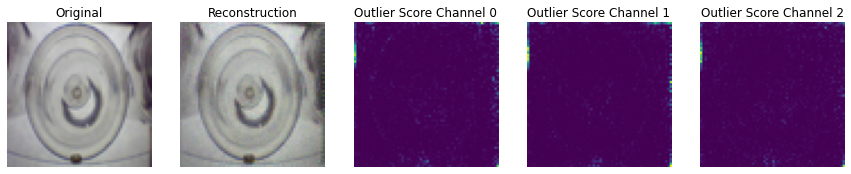

In [28]:
plot_feature_outlier_image(preds, test, 
                           X_recon=recon,  
                           max_instances=5,
                           outliers_only=False,
                           figsize=(15,15))